<a href="https://colab.research.google.com/github/gabrielhozana/AG-News-Model/blob/main/NLP_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset AG News

News articles of class "world", "sports", "business", and "Science"

In [ ]:
!pip install kaggle

from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes


This file consists of 120,000 training samples of news articles that contain 3 columns. The first column is Class Id, the second column is Title and the third column is Description. The class ids are numbered 1-4 where 1 represents World, 2 represents Sports, 3 represents Business and 4 represents Sci/Tech.

In [ ]:
'''
Sumber
https://www.kaggle.com/amananandrai/ag-news-classification-dataset?select=train.csv
'''
!kaggle datasets download -d amananandrai/ag-news-classification-dataset

 44% 5.00M/11.4M [00:00<00:00, 48.6MB/s]
100% 11.4M/11.4M [00:00<00:00, 72.4MB/s]


In [ ]:
!unzip ag-news-classification-dataset

Archive:  ag-news-classification-dataset.zip
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd 

df = pd.read_csv("train.csv")

In [ ]:
df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [ ]:
df.groupby('Class Index').nunique()

,Title,Description
Class Index,,
1,29004,29778
2,29212,29837
3,28569,29646
4,28163,29560


# Convert Dataframe to Array

In [ ]:
#concat column
x = df['Title']+" "+df['Description']
#convert to array
x = x.values
y = df['Class Index'].apply(lambda x:x-1).values

In [ ]:
print("X shape: ", x.shape)
print("Y shape: ", y.shape)

X shape:  (120000,)
Y shape:  (120000,)


# Split Dataset

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2)

# Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
     
tokenizer = Tokenizer(num_words=10000, oov_token='x')
tokenizer.fit_on_texts(x_train) 
tokenizer.fit_on_texts(x_test)
     
sequence_train = tokenizer.texts_to_sequences(x_train)
sequence_test = tokenizer.texts_to_sequences(x_test)
     
padded_train = pad_sequences(sequence_train,maxlen=100) 
padded_test = pad_sequences(sequence_test,maxlen=100)

# Model

In [ ]:
import tensorflow as tf
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=10000,output_dim=128,input_length=100),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True)),
                             tf.keras.layers.GlobalMaxPooling1D(),
                             tf.keras.layers.Dense(256, activation='relu'),                           
                             tf.keras.layers.Dense(128, activation='relu'),
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(4, activation='softmax')
                             ])
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 128)          1280000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 256)          263168    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 128)          164352    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)              

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.9 and logs.get('val_accuracy')>0.9):
      print("\nAkurasi telah mencapai >90%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
num_epochs = 30
history = model.fit(padded_train, y_train, epochs=num_epochs,validation_data=(padded_test, y_test),verbose=2, callbacks=[callbacks])

Epoch 1/30
3000/3000 - 1175s - loss: 0.3916 - accuracy: 0.8508 - val_loss: 0.2819 - val_accuracy: 0.9085
Epoch 2/30
3000/3000 - 1177s - loss: 0.2303 - accuracy: 0.9259 - val_loss: 0.2534 - val_accuracy: 0.9146

Akurasi telah mencapai >90%!


# Visualization 

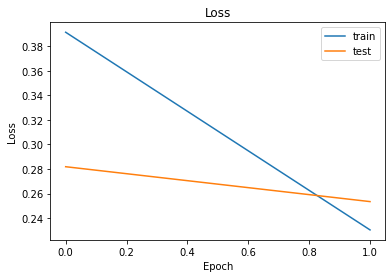

In [ ]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show();

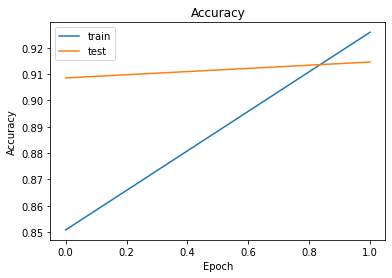

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show();

In [ ]:
# https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])